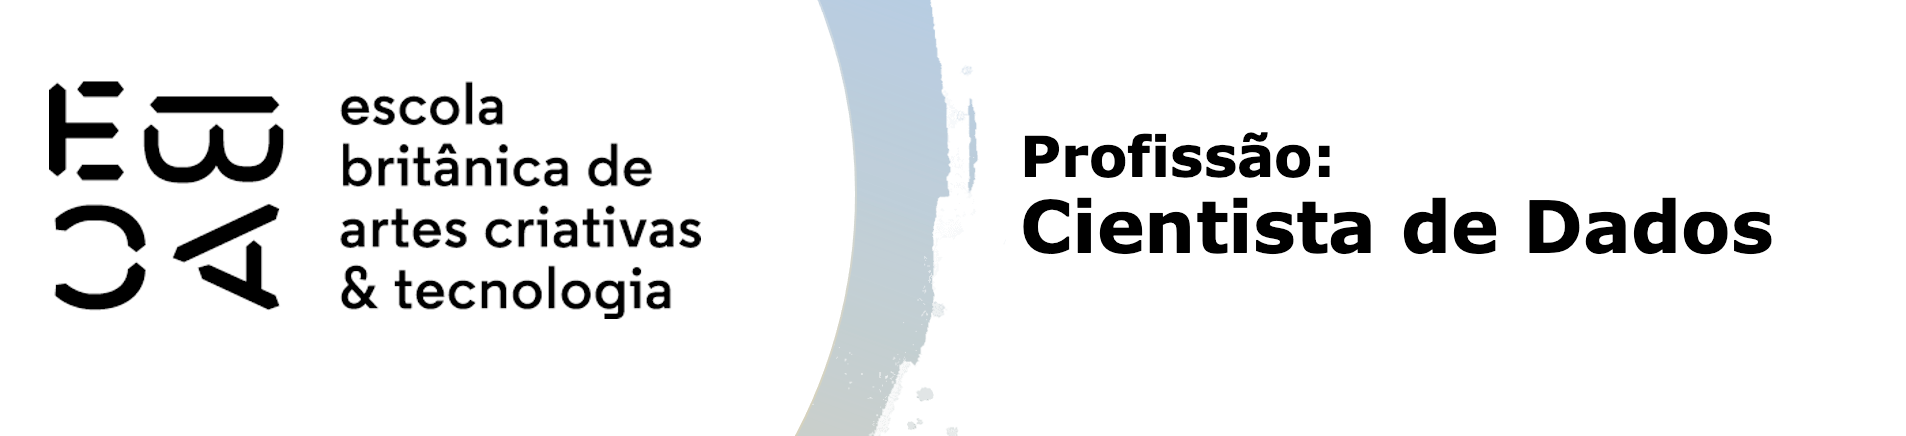

# Tarefa

Neste exercício vamos usar a base [online shoppers purchase intention](https://archive.ics.uci.edu/ml/datasets/Online+Shoppers+Purchasing+Intention+Dataset) de Sakar, C.O., Polat, S.O., Katircioglu, M. et al. Neural Comput & Applic (2018). [Web Link](https://doi.org/10.1007/s00521-018-3523-0).

A base trata de registros de 12.330 sessões de acesso a páginas, cada sessão sendo de um único usuário em um período de 12 meses, para posteriormente estudarmos a relação entre o design da página e o perfil do cliente - "Será que clientes com comportamento de navegação diferentes possuem propensão a compra diferente?" 

Nosso objetivo é tentar agrupar os clientes conforme seu comportamento de navegação entre páginas administrativas, informativas e de produtos. 

As variáveis estão descritas abaixo (em tradução livre do link indicado).

Por este motivo, o escopo desta análise estará fechado nas primeiras seis variáveis da tabela, referentes a quantidade e tempo de acesso por tipo de página, atributos que falam mais do comportamento de navegação do cliente que de características da página o da época do ano.

|Variavel                |Descrição          | 
|------------------------|:-------------------| 
|Administrative          | Quantidade de acessos em páginas administrativas| 
|Administrative_Duration | Tempo de acesso em páginas administrativas | 
|Informational           | Quantidade de acessos em páginas informativas  | 
|Informational_Duration  | Tempo de acesso em páginas informativas  | 
|ProductRelated          | Quantidade de acessos em páginas de produtos | 
|ProductRelated_Duration | Tempo de acesso em páginas de produtos | 
|BounceRates             | *Percentual de visitantes que entram no site e saem sem acionar outros *requests* durante a sessão  | 
|ExitRates               | * Soma de vezes que a página é visualizada por último em uma sessão dividido pelo total de visualizações | 
|PageValues              | * Representa o valor médio de uma página da Web que um usuário visitou antes de concluir uma transação de comércio eletrônico | 
|SpecialDay              | Indica a proximidade a uma data festiva (dia das mães etc) | 
|Month                   | Mês  | 
|OperatingSystems        | Sistema operacional do visitante | 
|Browser                 | Browser do visitante | 
|Region                  | Região | 
|TrafficType             | Tipo de tráfego                  | 
|VisitorType             | Tipo de visitante: novo ou recorrente | 
|Weekend                 | Indica final de semana | 
|Revenue                 | Indica se houve compra ou não |

\* variávels calculadas pelo google analytics

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.metrics import silhouette_score
from tqdm.notebook import tqdm

In [6]:
df = pd.read_csv('online_shoppers_intention.csv')

In [7]:
df.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False


In [8]:
df.shape

(12330, 18)

In [9]:
df.Revenue.value_counts(dropna=False)

Revenue
False    10422
True      1908
Name: count, dtype: int64

## Análise descritiva

Faça uma análise descritiva das variáveis do escopo.

- Verifique a distribuição dessas variáveis
- Veja se há valores *missing* e caso haja, decida o que fazer
- Faça mais algum tratamento nas variáveis caso ache pertinente

In [11]:
# Selecao das primeiras seis variáveis da tabela, referentes a quantidade e tempo de acesso por tipo de página
X = df[['Administrative', 'Administrative_Duration', 'Informational', 'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration']].copy()

# Distribuição das variaveis selecionadas
X.describe()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration
count,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000
mean,2.315166,80.818611,0.503569,34.472398,31.731468,1194.746220
std,3.321784,176.779107,1.270156,140.749294,44.475503,1913.669288
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,7.000000,184.137500
50%,1.000000,7.500000,0.000000,0.000000,18.000000,598.936905
75%,4.000000,93.256250,0.000000,0.000000,38.000000,1464.157214
max,27.000000,3398.750000,24.000000,2549.375000,705.000000,63973.522230


In [12]:
# Verificação de valores missing 
X.isna().sum()

Administrative             0
Administrative_Duration    0
Informational              0
Informational_Duration     0
ProductRelated             0
ProductRelated_Duration    0
dtype: int64

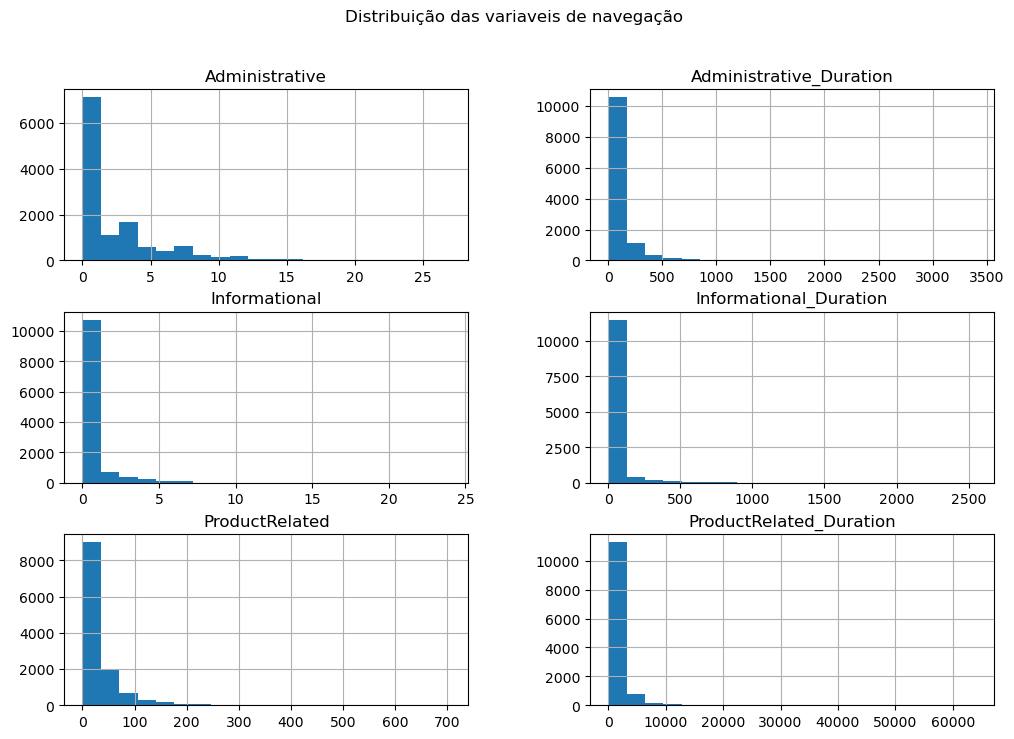

In [13]:
X.hist(bins=20, figsize=(12,8))
plt.suptitle('Distribuição das variaveis de navegação')
plt.show()

### Pelo gráfico acima podemos notar que as variaveis estao bem concentradas em zero e possuem escalas bem variadas.
### Irei padronizar as variaveis para garantir que as variaveis tenham a mesma escala.

In [15]:
X_pad = pd.DataFrame(StandardScaler().fit_transform(X), columns=X.columns)
X_pad.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration
0,-0.696993,-0.457191,-0.396478,-0.244931,-0.691003,-0.624348
1,-0.696993,-0.457191,-0.396478,-0.244931,-0.668518,-0.590903
2,-0.696993,-0.457191,-0.396478,-0.244931,-0.691003,-0.624348
3,-0.696993,-0.457191,-0.396478,-0.244931,-0.668518,-0.622954
4,-0.696993,-0.457191,-0.396478,-0.244931,-0.488636,-0.296430


## Número de grupos

Utilize as técnicas vistas em aula que te ajudem a decidir pelo número de grupos a ser utilizados.

  0%|          | 0/10 [00:00<?, ?it/s]

C:\Users\AJWork\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] O sistema não pode encontrar o arquivo especificado
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\AJWork\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\Users\AJWork\anaconda3\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\AJWork\anaconda3\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\Users\AJWork\anaconda3\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _w

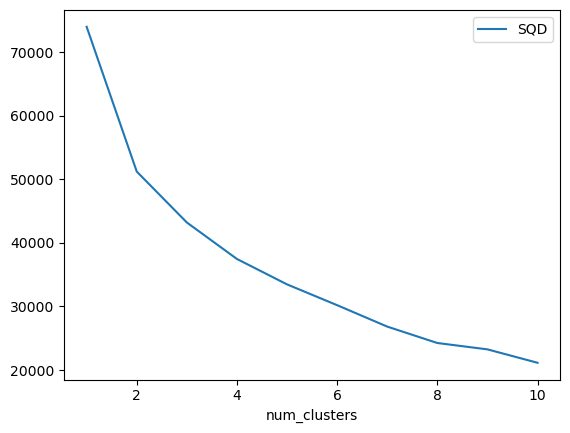

In [17]:
# Tecnica COTOVELO
SQD = []
K = range(1,11)
for k in tqdm(K):
    km = KMeans(n_clusters=k).fit(X_pad)
    SQD.append(km.inertia_)

cotovelo = pd.DataFrame({'num_clusters': list(range(1, len(SQD)+1)), 'SQD': SQD})
cotovelo.plot(x = 'num_clusters', y = 'SQD');

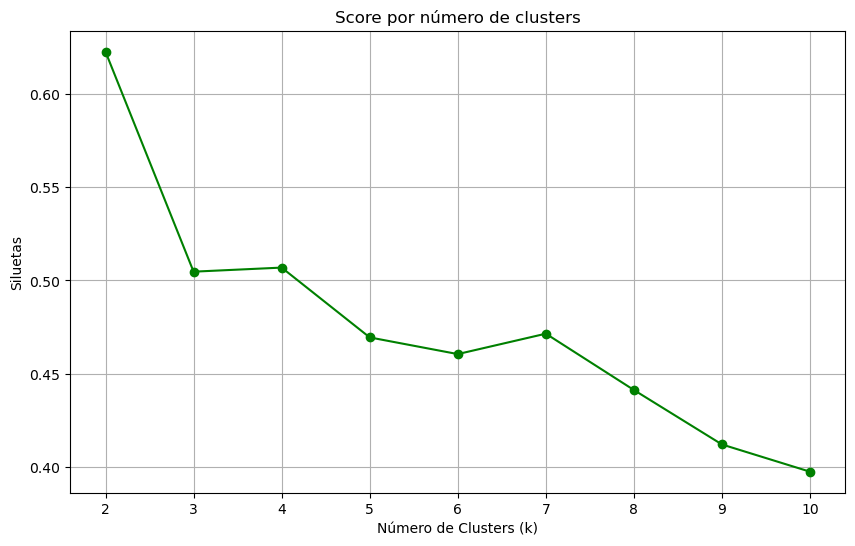

In [18]:
# Coeficiente de Siluetas
siluetas = []
K = range (2,11)
for k in K:
    km = KMeans(n_clusters=k, random_state=42).fit(X_pad)
    score = silhouette_score(X_pad, km.labels_)
    siluetas.append(score)

plt.figure(figsize=(10,6))
plt.plot(range(2, 11), siluetas, marker='o', color='green')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Siluetas')
plt.title('Score por número de clusters')
plt.grid(True)
plt.show()

## Avaliação dos grupos

Faça uma análise descritiva para pelo menos duas soluções de agrupamentos (duas quantidades diferentes de grupos) sugeridas no item anterior, utilizando as variáveis que estão no escopo do agrupamento.
- Com base nesta análise e nas análises anteriores, decida pelo agrupamento final. 
- Se puder, sugira nomes para os grupos.

**Com base nas análises do método do cotovelo e do Silhouette Score, testamos e avaliamos duas soluções de agrupamento:**

- K = 3 clusters
- K = 5 clusters

In [26]:
kmeans3 = KMeans(n_clusters=3, random_state=42)
df['grupos_3'] = kmeans3.fit_predict(X_pad)

kmeans5 = KMeans(n_clusters=5, random_state=42)
df['grupos_5'] = kmeans5.fit_predict(X_pad)

In [28]:
df.groupby('grupos_3')[['Administrative', 'Administrative_Duration',
                         'Informational', 'Informational_Duration',
                         'ProductRelated', 'ProductRelated_Duration', 'Revenue']].mean()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,Revenue
grupos_3,,,,,,,
0,6.523289,251.030033,0.973674,42.301835,55.539490,2056.320976,0.231268
1,7.058201,266.421802,4.086420,458.371554,138.380952,5731.105279,0.306878
2,0.907898,24.277938,0.160103,6.531608,18.900366,689.114236,0.125134


In [30]:
df.groupby('grupos_5')[['Administrative', 'Administrative_Duration',
                         'Informational', 'Informational_Duration',
                         'ProductRelated', 'ProductRelated_Duration', 'Revenue']].mean()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,Revenue
grupos_5,,,,,,,
0,5.582528,158.163005,0.644610,22.786428,52.605948,1937.690463,0.218959
1,5.628521,173.212603,4.290493,463.808375,59.989437,2452.205178,0.271127
2,0.714769,19.874827,0.133808,4.778345,16.818012,606.090667,0.118875
3,8.092050,278.490810,2.451883,177.884338,243.493724,9813.831265,0.347280
4,8.701149,903.156719,1.168582,64.489226,50.980843,2241.632696,0.241379


**Com base na interpretação, o agrupamento com K=5 foi escolhido como a solução final, porque:**

- Apresenta grupos mais distintos.
- Identifica um grupo Premium (alta propensão à compra).
- Identifica um grupo Frio (alta rejeição).
- Permite uma segmentação mais rica e ações de marketing mais personalizadas.

**Sugestão de nomes para os grupos (K=5**
- **Cluster 0**: Interessados moderados 
- **Cluster 1**: Pesquisadores curiosos 
- **Cluster 2**: Visitantes rápidos
- **Cluster 3**: Clientes quentes
- **Cluster 4**: Compradores indecisos


## Avaliação de resultados

Avalie os grupos obtidos com relação às variáveis fora do escopo da análise (minimamente *bounce rate* e *revenue*). 
- Qual grupo possui clientes mais propensos à compra?

In [35]:
df.groupby('grupos_3')['BounceRates'].mean()

grupos_3
0    0.006500
1    0.006750
2    0.027302
Name: BounceRates, dtype: float64

In [37]:
pd.crosstab(df['grupos_3'], df['Revenue'], normalize='index') * 100

Revenue,False,True
grupos_3,,
0,76.873228,23.126772
1,69.312169,30.687831
2,87.486550,12.513450


**Análise para K=3 (três grupos)**
- Grupo 1 tem a melhor taxa de compra (30,7%), o que é bem superior aos outros dois.
- Grupo 2 tem a maior rejeição (Bounce Rate = 2,7%) e a menor taxa de compra (12,5%).
- Isso sugere que o Grupo 1 representa os clientes mais interessados à compra, enquanto o Grupo 2 representa visitantes que entram e olham mas não compram.

In [40]:
df.groupby('grupos_5')['BounceRates'].mean()

grupos_5
0    0.006677
1    0.007683
2    0.028970
3    0.005324
4    0.006465
Name: BounceRates, dtype: float64

In [42]:
pd.crosstab(df['grupos_5'], df['Revenue'], normalize='index') * 100

Revenue,False,True
grupos_5,,
0,78.104089,21.895911
1,72.887324,27.112676
2,88.112459,11.887541
3,65.271967,34.728033
4,75.862069,24.137931


**Análise para K=5 (cinco grupos)**

- Grupo 3 se destaca como o melhor grupo de clientes, com a maior taxa de compra (34,7%) e a menor taxa de rejeição (0,53%).
- Grupo 2 é o pior grupo, com uma taxa de rejeição alta (2,9%) e a menor taxa de compra (11,89%).
- O agrupamento com K=5 parece identificar melhor subgrupos de comportamento, especialmente diferenciando ainda mais os visitantes mais qualificados (grupo 3).